# Model training: Support Vector Machine

We use Support Vector Machine to obtain our prediction model. As opposed to previous strategy, we also do cross-validation on the tfidf features.

In [1]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline

### Loading the data 

In [2]:
path = '/Users/louispht/Dropbox/git_projects/news_classifier/Data cleaning/Pickles/'

# X_train
with open(path + 'X_train_noact.pickle', 'rb') as data:
    X_train = pickle.load(data)
    
# X_test
with open(path + 'X_test_noact.pickle', 'rb') as data:
    X_test = pickle.load(data)

# y_train
with open(path + 'y_train_noact.pickle', 'rb') as data:
    y_train = pickle.load(data)
    
# y_test
with open(path + 'y_test_noact.pickle', 'rb') as data:
    y_test = pickle.load(data)

In [3]:
X_train.shape

(8641,)

In [4]:
y_train.shape

(8641,)

In [5]:
X_test.shape

(1130,)

In [6]:
y_test.shape

(1130,)

### Defining the pipeline and do RandomSearchCV

In [7]:
pipeline = Pipeline([('tfidf', TfidfVectorizer(encoding='utf-8',
                        stop_words=None,
                        lowercase=False,
                        norm='l2',
                        sublinear_tf=True)),
                     ('svc', svm.SVC())])

In [8]:
# Create the random grid
random_grid = {'svc__C': [.0001, .001, .01, .1, 1.0, 10.0],
               'svc__kernel': ['linear', 'rbf', 'poly'],
               'svc__gamma': [0.001, .001, .01, .1, 1, 10, 100],
               'svc__degree': [1,2,3,4,5],
               'tfidf__ngram_range':((1,1), (1,2)),
               'tfidf__max_features':[500, 1000, 5000, 10000, 15000],
               'tfidf__max_df': (0.5,0.75,1.0)
             }

In [9]:
# Definition of the random search
random_search = RandomizedSearchCV(estimator=pipeline,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   verbose=1, 
                                   random_state=42)

# Fit the random search model
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 366.9min finished


RandomizedSearchCV(estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(lowercase=False,
                                                              sublinear_tf=True)),
                                             ('svc', SVC())]),
                   n_iter=50,
                   param_distributions={'svc__C': [0.0001, 0.001, 0.01, 0.1,
                                                   1.0, 10.0],
                                        'svc__degree': [1, 2, 3, 4, 5],
                                        'svc__gamma': [0.001, 0.001, 0.01, 0.1,
                                                       1, 10, 100],
                                        'svc__kernel': ['linear', 'rbf',
                                                        'poly'],
                                        'tfidf__max_df': (0.5, 0.75, 1.0),
                                        'tfidf__max_features': [500, 1000, 5000,
                                    

In [10]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is: % .2f" % random_search.best_score_)

The best hyperparameters from Random Search are:
{'tfidf__ngram_range': (1, 1), 'tfidf__max_features': 15000, 'tfidf__max_df': 0.75, 'svc__kernel': 'linear', 'svc__gamma': 100, 'svc__degree': 3, 'svc__C': 10.0}

The mean accuracy of a model with these hyperparameters is:  0.94


In [11]:
#Save the best model
best_svc = random_search.best_estimator_
best_svc

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, max_df=0.75,
                                 max_features=15000, sublinear_tf=True)),
                ('svc', SVC(C=10.0, gamma=100, kernel='linear'))])

In [12]:
best_svc.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, max_df=0.75,
                                 max_features=15000, sublinear_tf=True)),
                ('svc', SVC(C=10.0, gamma=100, kernel='linear'))])

In [13]:
#predictions 
svc_pred = best_svc.predict(X_test)

#### Saving the model

In [14]:
d = {
     'Model': 'SVM',
     'Training Set Accuracy': accuracy_score(y_train, best_svc.predict(X_train)),
     'Test Set Accuracy': accuracy_score(y_test, svc_pred)
}

df_models_svc = pd.DataFrame(d, index=[0])

In [15]:
df_models_svc

,Model,Training Set Accuracy,Test Set Accuracy
0,SVM,0.991205,0.937168


In [16]:
with open('Models/best_svc_pipeline.pickle', 'wb') as output:
    pickle.dump(best_svc, output)
    
with open('Models/df_models_svc_pipeline.pickle', 'wb') as output:
    pickle.dump(df_models_svc, output)

### Performance Analysis 

In [17]:
# Classification report
categories = {'affaires':0, 'sports':3, 'international':2, 'culture':1}
print("Classification report")
print(classification_report(y_test,svc_pred, target_names=categories))

Classification report
               precision    recall  f1-score   support

     affaires       0.91      0.92      0.91       243
       sports       0.95      0.89      0.92       274
international       0.87      0.95      0.91       220
      culture       0.99      0.97      0.98       393

     accuracy                           0.94      1130
    macro avg       0.93      0.93      0.93      1130
 weighted avg       0.94      0.94      0.94      1130



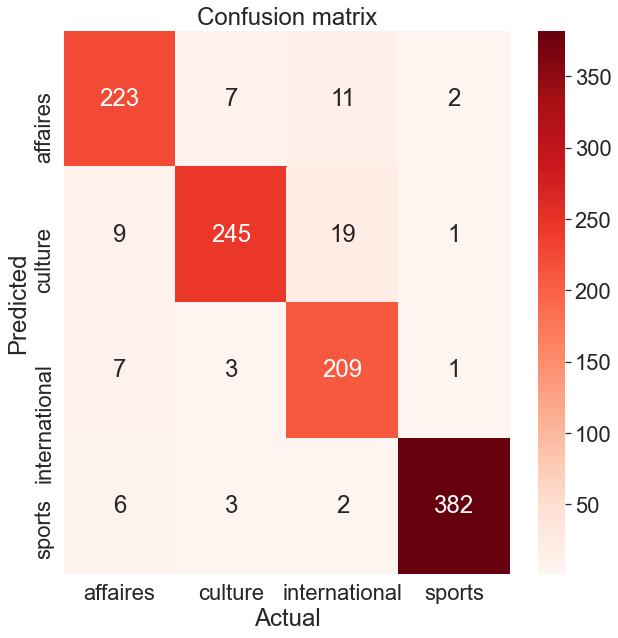

In [29]:
#Confusion matrix
#aux_df = df_all_le[['category', 'label_enc']].drop_duplicates().sort_values('category')
conf_matrix = confusion_matrix(y_test, svc_pred)
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=['affaires', 'culture', 'international', 'sports'],
            yticklabels=['affaires', 'culture', 'international', 'sports'],
            cmap="Reds",
            fmt = '.3g')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.savefig('conf_mat_svm.png', transparent = True)
plt.show()